<a href="https://colab.research.google.com/github/2SEHI/Factory-Anomaly-Analysis/blob/main/2_382%EA%B0%9C%EC%9D%98_%EC%BB%AC%EB%9F%BC_PCA%EC%99%80_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3가지의 정규화를 이용한 PCA주성분 분석결과 비교
- 데이터 스케일링은 MinMaxScaler, StandardScaler, LogScaler 3가지를 확인해봄

## 1.데이터 스케일링의 종류와 개념

### 1) MinMaxScaler
- 모든 feature를 0~1 사이의 값으로 조정
- 단점 : 이상치가 있다면, 매우 좁은 범위로 압출될 수 있음

### 2) StandardScaler를 이용한 PCA주성분 분석
- 평균과 표준편차를 이용 (x - mean)/(std_deviation)
- 단점 : 이상치가 있으면 변환된 데이터 확산이 매우 달라져 균형잡힌 척도 보장 X
- 넓게 분포된 데이터 보다는 모여진 데이터가 예측률이 좋다



### 3) RobustScaler를 이용한 PCA주성분 분석
- Standard Scaler 와 비슷하지만 평균대신 중앙값 사용 => 극단값(이상치, outlier)에 영향을 받지 않는다


## 2.공통 모듈 임포트

In [ ]:
# colab에서 실행시 matplotlib에 한글을 표시하기 위해서 본 셀을 실행후 runtime을 재시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Display_Sensor_Anomaly_Analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.함수 생성

### 1) 데이터 스케일링결과를 반환하는 함수

In [3]:
def scale(feature_data):
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(feature_data))
    feature_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    # from sklearn.preprocessing import MaxAbsScaler
    # maxAbsScaler = MaxAbsScaler()
    # %time print(maxAbsScaler.fit(feature_data))
    # feature_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(feature_data))
    feature_data_standardScaled = pd.DataFrame(standardScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(feature_data))
    feature_data_robustScaled = pd.DataFrame(robustScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)
    return feature_data_minMaxScaled, feature_data_standardScaled, feature_data_robustScaled

### 2) pca주성분 결과의 누적 기여율이 90%가 되는 피처개수를 구하는 함수

In [4]:
def get_pca(feature_data, n_components=2):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    pca.fit(feature_data)
    feature_data_pca = pca.transform(feature_data)
    if n_components==2 :
        feature_data_pca =  pd.DataFrame(data=feature_data_pca, columns=['PC1','PC2'], index=feature_data.index)
        print(feature_data_pca)
        sns.scatterplot(x=feature_data_pca.iloc[:,0], y=feature_data_pca.iloc[:,1])
    else :
        draw_elbowpoint(pca)
        # 주성분의 설명력과 기여율 구하기
        result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
                    '기여율':pca.explained_variance_ratio_},
                    index=np.array([f"pca{num+1}" for num in range(feature_data_pca.shape[1])]))
        result['누적기여율'] = result['기여율'].cumsum()
        print_cumsum90(result)
        print('<전체 누적기여율>\n', result)

In [5]:
def print_cumsum90(result):
    result_mask = result['누적기여율'] <= 0.9
    print('누적기여율이 90%가 되는 피처의 수 : ', len(result[result_mask]))
    print(result[result_mask].tail(5))

### 3) Elbow Point그리는 함수

In [6]:
def draw_elbowpoint(pca):
    plt.figure(figsize=(16, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o', c='blue')
    plt.xlabel("n_components", fontsize=20)
    plt.ylabel("explained_variance_ratio_", fontsize=20)

# 🎈VIF까지 마친 데이터

## 1.피처와 레이블데이터 불러오기
- 피처의 크기 : 8145 rows × 165 columns(dat...date.name.는 index임)
- 레이블의 크기 : 8145 rows × 4 columns

In [7]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_VIF_feature = pd.read_csv(working_dir + 'fact_lr_VIF_feature.csv', index_col=0)
fact_lr_labels = pd.read_csv(working_dir + 'fact_lr_labels.csv', index_col=0)

print(fact_lr_VIF_feature.shape)
print(fact_lr_labels.shape)

(8145, 165)
(8145, 4)


## 2.데이터스케일링

### 1) 데이터스케일링 하기전 피처의 통계정보확인

In [8]:
fact_lr_VIF_feature.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,0.000865,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.002465,0.000362,0.000672,0.000133,0.000599,-0.000518,-0.000462,-0.000374,0.000010,-0.000065,-0.000015,0.000020,-0.002179,0.000004,0.000248,0.000088,0.000015,-0.000738,-0.000007,-0.000013,-0.000010,0.000115,-0.000010,0.000586,-0.001312,0.000114,-0.000012,0.000059,...,0.000414,0.000162,0.000264,0.000042,0.000753,0.001017,0.001362,0.000378,0.001271,0.000974,0.001102,0.001712,-0.000583,0.000253,-0.000464,-0.000169,-0.000120,0.000321,-0.000605,-0.000147,-0.000585,0.000553,0.000667,0.000614,-0.000795,0.000196,0.000196,0.001021,-0.000788,-0.000435,0.000010,0.000490,-0.000193,-0.000032,0.000028,0.000325,-0.000536,-0.000530,-0.000437,0.000242
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.999994,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,0.996887,1.000346,1.000141,1.000417,1.000221,1.000273,1.000305,1.000348,1.000430,1.000427,1.000430,1.000429,0.996634,1.000430,1.000394,1.000425,1.000430,1.000113,1.000430,1.000430,1.000430,1.000422,1.000430,1.000229,0.999675,1.000360,1.000368,1.000366,...,1.000329,1.000414,1.000388,1.000427,1.000099,0.999827,0.999342,1.000344,0.999486,0.999875,0.999720,0.998717,1.000231,1.000391,1.000302,1.000411,1.000420,1.000369,1.00021

### 2) 데이터 스케일링결과 취득

In [9]:
X_mm_VIF_scaled, X_std_VIF_scaled, X_rbs_VIF_scaled =  scale(fact_lr_VIF_feature)

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 6.25 ms, sys: 47 µs, total: 6.29 ms
Wall time: 6.3 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 19.6 ms, sys: 3.95 ms, total: 23.5 ms
Wall time: 23.5 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 58.8 ms, sys: 0 ns, total: 58.8 ms
Wall time: 58.9 ms


## 3.주성분분석

### 1) 스케일링 안한 데이터

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  57
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca53          0.751401  0.004554  0.883674
pca54          0.707291  0.004287  0.887961
pca55          0.685500  0.004155  0.892116
pca56          0.670267  0.004063  0.896178
pca57          0.614168  0.003723  0.899901
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1           25.034596  0.151738  0.151738
pca2           14.227044  0.086232  0.237970
pca3            9.620864  0.058313  0.296283
pca4            7.715375  0.046764  0.343047
pca5            6.119732  0.037092  0.380140
...                  ...       ...       ...
pca161          0.016936  0.000103  0.999674
pca162          0.015368  0.000093  0.999767
pca163          0.015149  0.000092  0.999859
pca164          0.012510  0.000076  0.999935
pca165          0.010710  0.000065  1.000000

[165 rows x 3 columns]


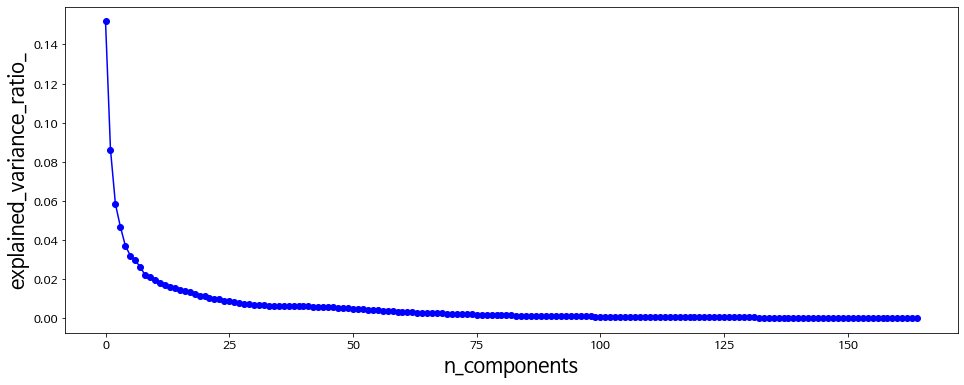

In [11]:
get_pca(fact_lr_VIF_feature, len(fact_lr_VIF_feature.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     14.233546  3.440223
2016-01-01 08     13.258277  3.225937
2016-01-01 09     14.291299  3.284085
2016-01-01 10     14.082900  3.561778
2016-01-01 11     15.370156  3.841773
...                     ...       ...
2016-12-31 19     -0.660706  5.670001
2016-12-31 20     -0.212526  6.012899
2016-12-31 21     -0.383798  5.508100
2016-12-31 22      0.113666  5.910948
2016-12-31 23     -0.098277  5.875143

[8145 rows x 2 columns]


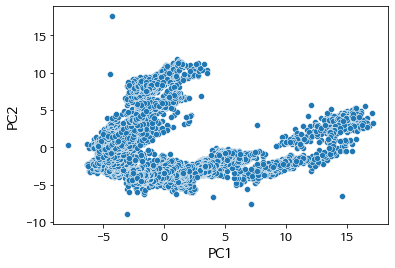

In [129]:
get_pca(fact_lr_VIF_feature)

### 2) MinMaxScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  29
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca25          0.018575  0.005846  0.876048
pca26          0.017928  0.005642  0.881690
pca27          0.016154  0.005084  0.886774
pca28          0.015712  0.004944  0.891718
pca29          0.015173  0.004775  0.896493
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1            0.824083  0.259334  0.259334
pca2            0.422667  0.133011  0.392345
pca3            0.313368  0.098615  0.490960
pca4            0.170837  0.053761  0.544721
pca5            0.119679  0.037662  0.582383
...                  ...       ...       ...
pca161          0.000039  0.000012  0.999976
pca162          0.000025  0.000008  0.999983
pca163          0.000024  0.000007  0.999991
pca164          0.000016  0.000005  0.999996
pca165          0.000012  0.000004  1.000000

[165 rows x 3 columns]


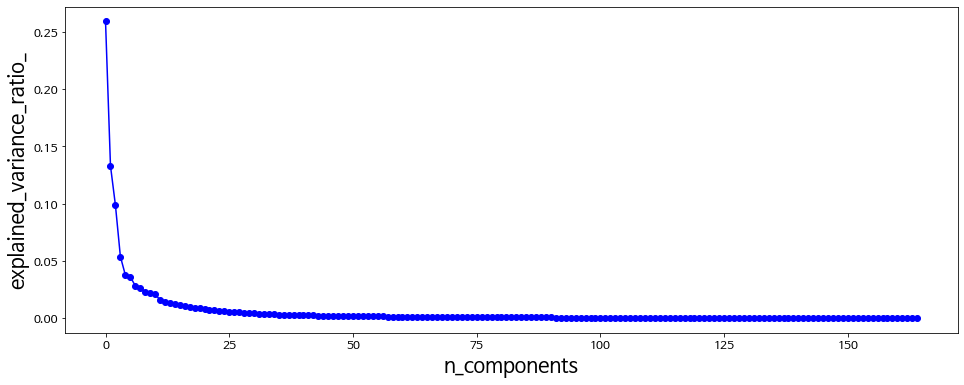

In [12]:
get_pca(X_mm_VIF_scaled, len(X_mm_VIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     14.233546  3.440223
2016-01-01 08     13.258277  3.225937
2016-01-01 09     14.291299  3.284085
2016-01-01 10     14.082900  3.561778
2016-01-01 11     15.370156  3.841773
...                     ...       ...
2016-12-31 19     -0.660706  5.670001
2016-12-31 20     -0.212526  6.012899
2016-12-31 21     -0.383798  5.508100
2016-12-31 22      0.113666  5.910948
2016-12-31 23     -0.098277  5.875143

[8145 rows x 2 columns]


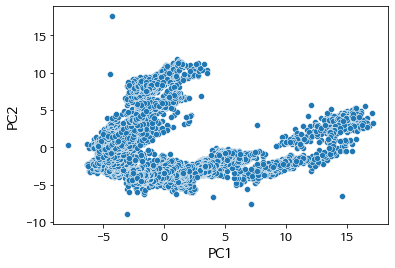

In [ ]:
get_pca(X_mm_VIF_scaled)

### 3) StandardScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  57
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca53          0.751385  0.004553  0.883662
pca54          0.707362  0.004287  0.887949
pca55          0.685567  0.004154  0.892103
pca56          0.670557  0.004063  0.896167
pca57          0.614292  0.003723  0.899889
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1           25.035410  0.151711  0.151711
pca2           14.242599  0.086308  0.238019
pca3            9.632294  0.058370  0.296390
pca4            7.716688  0.046762  0.343152
pca5            6.119540  0.037084  0.380235
...                  ...       ...       ...
pca161          0.016939  0.000103  0.999674
pca162          0.015368  0.000093  0.999767
pca163          0.015145  0.000092  0.999859
pca164          0.012513  0.000076  0.999935
pca165          0.010710  0.000065  1.000000

[165 rows x 3 columns]


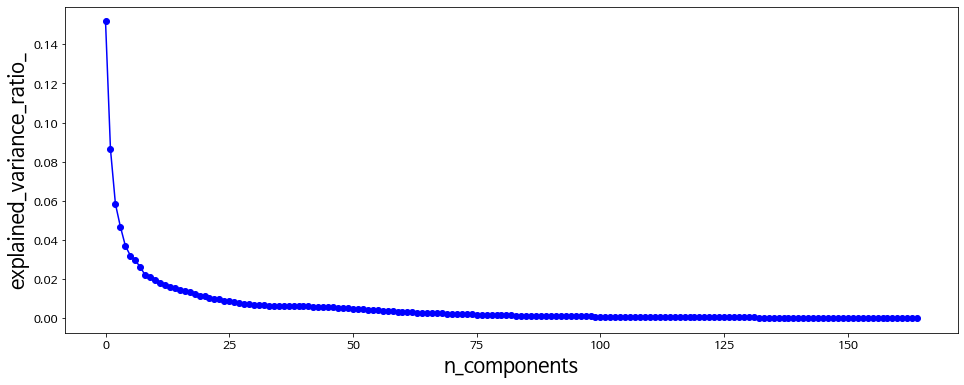

In [13]:
get_pca(X_std_VIF_scaled, len(X_std_VIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     14.234109  3.433022
2016-01-01 08     13.258980  3.218862
2016-01-01 09     14.292343  3.276016
2016-01-01 10     14.083612  3.553977
2016-01-01 11     15.371416  3.832951
...                     ...       ...
2016-12-31 19     -0.654109  5.707979
2016-12-31 20     -0.205520  6.053339
2016-12-31 21     -0.376069  5.548046
2016-12-31 22      0.122695  5.951194
2016-12-31 23     -0.090187  5.912871

[8145 rows x 2 columns]


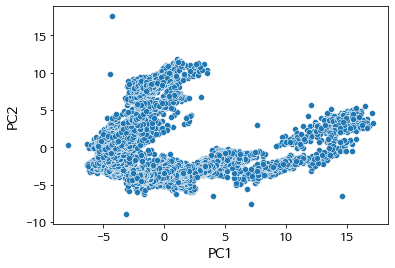

In [14]:
get_pca(X_std_VIF_scaled)

### 4) RobustScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  0
Empty DataFrame
Columns: [설명가능한 분산 비율(고윳값), 기여율, 누적기여율]
Index: []
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        2.504110e+08  9.512326e-01  0.951233
pca2        1.270566e+07  4.826481e-02  0.999497
pca3        1.250997e+05  4.752144e-04  0.999973
pca4        4.546603e+03  1.727111e-05  0.999990
pca5        1.279461e+03  4.860269e-06  0.999995
...                  ...           ...       ...
pca161      1.020557e-02  3.876773e-11  1.000000
pca162      9.509161e-03  3.612231e-11  1.000000
pca163      8.423451e-03  3.199804e-11  1.000000
pca164      7.237756e-03  2.749396e-11  1.000000
pca165      6.361437e-03  2.416509e-11  1.000000

[165 rows x 3 columns]


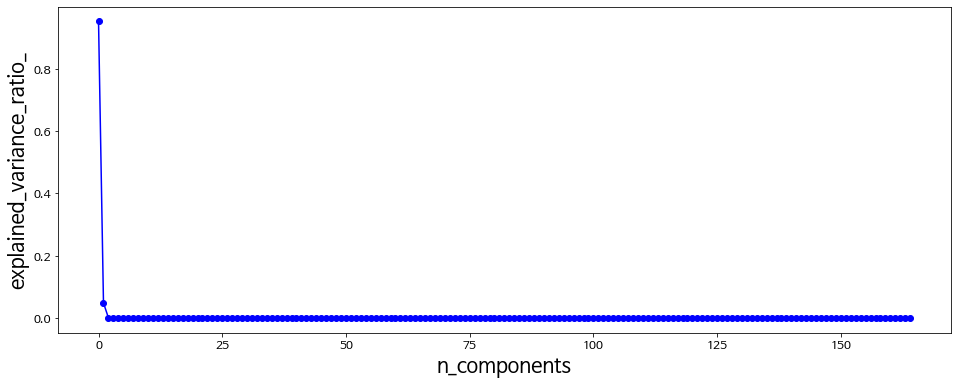

In [15]:
get_pca(X_rbs_VIF_scaled, len(X_rbs_VIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                           PC1           PC2
dat...date.name.                            
2016-01-01 07     98678.349797  19199.552678
2016-01-01 08     -1313.311217  16120.007807
2016-01-01 09     -1322.056604  19208.483139
2016-01-01 10     -1318.621284  17995.223404
2016-01-01 11     -1322.169598  19247.771322
...                        ...           ...
2016-12-31 19     -1265.781533   -739.604578
2016-12-31 20     -1265.751370   -739.123578
2016-12-31 21     -1283.035120   5493.079694
2016-12-31 22     -1302.502019  12367.664389
2016-12-31 23     -1284.805041   6118.152342

[8145 rows x 2 columns]


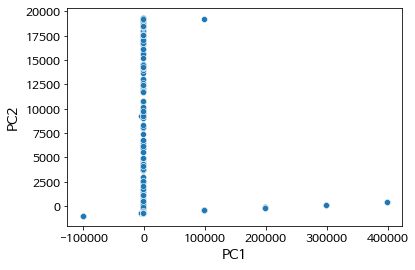

In [16]:
get_pca(X_rbs_VIF_scaled)

# 🎈VIF계수를 이용하여 컬럼제거 안한 데이터

## 1.피처와 레이블데이터 불러오기
- 피처의 크기 : 8145 rows × 324 columns(dat...date.name.는 index임)
- 레이블의 크기 : 8145 rows × 4 columns

In [19]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_noVIF_feature = pd.read_csv(working_dir + 'fact_lr_noVIF_feature.csv', index_col=0)

print(fact_lr_noVIF_feature.shape)

(8145, 324)


## 2.데이터스케일링

### 1) 데이터스케일링 하기전 피처의 통계정보확인

In [20]:
fact_lr_noVIF_feature.describe()

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,X1WOS45101_PV,X1WOS45105_PV,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DCS_Offset_RPM_M16.1WOS45116_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DAMP.POSITION.1.BAY.CTRL.1TIC33421.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ROOF.HEATING.Zone.7.1JIC31107.PV,ROOF.HEATING.Zone.8.1JIC31108.PV,ROOF.HEATING.Zone.9.1JIC31109.PV,ATM.FLOW.SECT.8.N2.H2.1FI33414.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,cluster,Gross.width,Left.edge,UPPER.AB1.Z1.TMP.1TIC41101.PV,UPPER.AB1.Z6.TMP.1TIC41106.PV,LOWER.AB1.Z9.TMP.1TIC41152.PV,UPPER.AB2.Z20.TMP.1TIC41206.PV,LOWER.AB3.Z37.TMP.1TIC41352.PV,UPPER.AB5.Z57.TMP.1TIC41501.PV,LOWER.AB5.Z67.TMP.1TIC41554.PV,LOWER.AB5.Z69.TMP.1TIC41556.PV,UPPER.AB6.Z71.TMP.1TIC41601.PV,LOWER.AB6.Z78.TMP.1TIC41651.PV,LOWER.AB6.Z83.TMP.1TIC41656.PV,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.AB8.Z99.TMP.1TIC41801.PV,UPPER.AB8.Z101TMP.1TIC41803.PV,UPPER.AB8.Z102.TMP.1TIC41804.PV,...,D_C1_L_UL,D_C2_L_UL,D_C3_L_UL,D_GLS_AB1_LR,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_C4_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB1_AB2_L_L,S_AB2_AB3_U_L,S_AB2_AB3_L_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB6_AB7_L_L,S_AB7_AB8_U_L,S_AB7_AB8_L_L,S_AB8_AB9_U_L,S_AB8_AB9_L_L,S_AB9_AB10_U_L,S_AB9_AB10_L_L,S_AB10_AB11_U_L,S_AB10_AB11_L_L,S_AB11_C1_U_L,S_AB11_C1_L_L,S_C1_C2_U_L,S_C1_C2_L_L,S_C2_C3_U_L,S_C2_C3_L_L,S_C3_C4_U_L,S_AB1_AB11_L,S_AB11_AB7_L,S_AB7_C4_L,S_C4_RET_L,S_RET_F_L,STD_U_L,STD_GLS_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,0.000728,-0.000184,-0.000456,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,-0.000258,0.000865,0.000080,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.000515,-0.000324,-0.000607,-0.001575,-0.002465,-0.001554,0.000362,0.000672,-0.000376,-0.000477,-0.000248,-0.000077,0.000236,-0.000101,0.000139,0.000291,0.000133,0.000194,0.000253,0.000096,-0.000270,0.000408,0.000631,...,0.000244,-0.000795,-0.000938,0.000963,0.000196,0.001651,-0.000188,0.000196,0.001021,-0.000788,-0.000770,-0.000435,-0.000014,0.000010,0.000490,-0.000193,-0.000032,0.000043,0.000028,0.000036,0.000203,0.000335,0.000325,0.000005,-0.000254,-0.000536,-0.000230,0.000028,0.000592,-0.000530,-0.000501,-0.000437,0.000242,-0.000673,0.000358,0.000159,-0.001295,0.000231,0.000351,-0.000434
std,1.000121,1.000407,1.000309,1.000423,1.000427,1.000427,1.000420,1.000407,1.000391,0.999994,1.000426,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,1.000275,1.000369,1.000215,0.998984,0.996887,0.999022,1.000346,1.000141,1.000347,1.000297,1.000394,1.000426,1.000397,1.000423,1.000417,1.000380,1.000417,1.000407,1.000392,1.000423,1.000387,1.000332,1.000197,...,1.000327,0.999924,0.999803,0.999890,1.000403,0.998840,1.000407,1.000402,0.999817,1.000066,1.000084,1.000319,1.000429,1.000429,1.000289,1.000407,1.000429,1.000428,1.000428,1.000427,1.000405,1.000364,1.000367,1.000430,1.000392,1.000257,1.000399,1

### 2) 데이터 스케일링결과 취득

In [21]:
X_mm_noVIF_scaled, X_std_noVIF_scaled, X_rbs_noVIF_scaled =  scale(fact_lr_noVIF_feature)

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 10.9 ms, sys: 731 µs, total: 11.6 ms
Wall time: 13.2 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 38.9 ms, sys: 3.76 ms, total: 42.7 ms
Wall time: 43 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 108 ms


## 3.주성분분석

### 1) 스케일링 안한 데이터

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  49
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca45          1.002432  0.003094  0.887606
pca46          1.001101  0.003090  0.890696
pca47          0.997168  0.003078  0.893773
pca48          0.996670  0.003076  0.896850
pca49          0.980524  0.003026  0.899876
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        6.556426e+01  2.023615e-01  0.202361
pca2        3.626428e+01  1.119283e-01  0.314290
pca3        2.357826e+01  7.277336e-02  0.387063
pca4        1.738115e+01  5.364622e-02  0.440709
pca5        1.603091e+01  4.947878e-02  0.490188
...                  ...           ...       ...
pca320      8.116243e-20  2.505047e-22  1.000000
pca321      8.044306e-20  2.482843e-22  1.000000
pca322      7.897378e-20  2.437495e-22  1.000000
pca323      7.751026e-20  2.392324e-22  1.000000
pca324      7.718161e-20  2.382180e-22  1.000000

[324 rows x 3 columns]


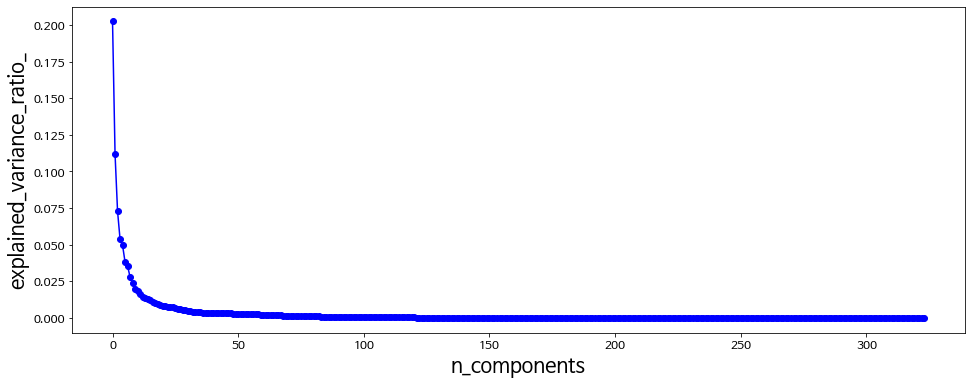

In [22]:
get_pca(fact_lr_noVIF_feature, len(fact_lr_noVIF_feature.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     22.135676 -7.977359
2016-01-01 08     21.579658 -7.797956
2016-01-01 09     22.199069 -7.895591
2016-01-01 10     21.949192 -8.009232
2016-01-01 11     22.953605 -8.112407
...                     ...       ...
2016-12-31 19     -1.218127 -8.855157
2016-12-31 20     -1.001158 -9.207070
2016-12-31 21     -1.042699 -8.789396
2016-12-31 22     -0.800874 -8.879896
2016-12-31 23     -0.905449 -9.027725

[8145 rows x 2 columns]


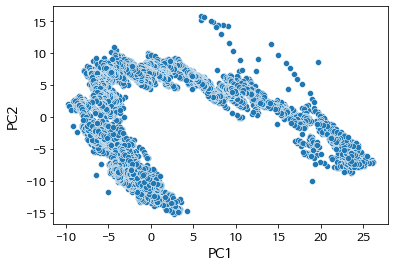

In [23]:
get_pca(fact_lr_noVIF_feature)

### 2) MinMaxScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  23
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca19          0.052316  0.007132  0.874234
pca20          0.045991  0.006270  0.880503
pca21          0.041998  0.005725  0.886228
pca22          0.040721  0.005551  0.891780
pca23          0.037308  0.005086  0.896865
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        2.361021e+00  3.218582e-01  0.321858
pca2        1.078207e+00  1.469829e-01  0.468841
pca3        7.324637e-01  9.985062e-02  0.568692
pca4        3.995449e-01  5.446659e-02  0.623158
pca5        3.081027e-01  4.200105e-02  0.665159
...                  ...           ...       ...
pca320      9.561049e-22  1.303377e-22  1.000000
pca321      7.409104e-22  1.010021e-22  1.000000
pca322      6.537417e-22  8.911910e-23  1.000000
pca323      4.665133e-22  6.359584e-23  1.000000
pca324      4.493219e-22  6.125228e-23  1.000000

[324 rows x 3 columns]


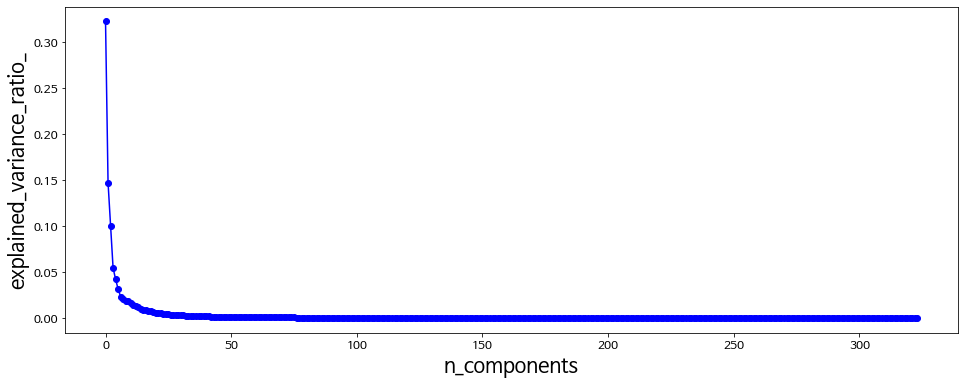

In [24]:
get_pca(X_mm_noVIF_scaled, len(X_mm_noVIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                       PC1       PC2
dat...date.name.                    
2016-01-01 07     3.452587  1.529799
2016-01-01 08     3.437222  1.511311
2016-01-01 09     3.464805  1.526781
2016-01-01 10     3.467175  1.539693
2016-01-01 11     3.532527  1.550058
...                    ...       ...
2016-12-31 19    -0.409801  2.174725
2016-12-31 20    -0.391770  2.202924
2016-12-31 21    -0.373658  2.184747
2016-12-31 22    -0.358247  2.216913
2016-12-31 23    -0.364460  2.222958

[8145 rows x 2 columns]


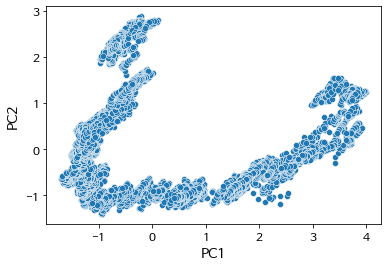

In [25]:
get_pca(X_mm_noVIF_scaled)

### 3) StandardScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  49
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca45          1.001766  0.003091  0.887600
pca46          1.000446  0.003087  0.890688
pca47          0.996532  0.003075  0.893763
pca48          0.995987  0.003074  0.896837
pca49          0.980041  0.003024  0.899861
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        6.556093e+01  2.023237e-01  0.202324
pca2        3.628818e+01  1.119868e-01  0.314311
pca3        2.360103e+01  7.283373e-02  0.387144
pca4        1.737479e+01  5.361932e-02  0.440764
pca5        1.602976e+01  4.946851e-02  0.490232
...                  ...           ...       ...
pca320      8.113479e-20  2.503853e-22  1.000000
pca321      8.048906e-20  2.483925e-22  1.000000
pca322      7.895233e-20  2.436501e-22  1.000000
pca323      7.752377e-20  2.392415e-22  1.000000
pca324      7.715447e-20  2.381019e-22  1.000000

[324 rows x 3 columns]


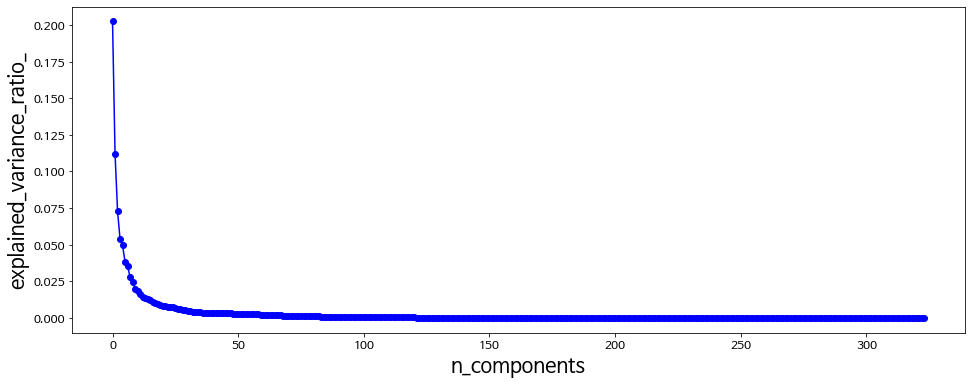

In [26]:
get_pca(X_std_noVIF_scaled, len(X_std_noVIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     22.133983 -7.972726
2016-01-01 08     21.578034 -7.792859
2016-01-01 09     22.198145 -7.890572
2016-01-01 10     21.947679 -8.004246
2016-01-01 11     22.953332 -8.107318
...                     ...       ...
2016-12-31 19     -1.213538 -8.894385
2016-12-31 20     -0.996210 -9.249024
2016-12-31 21     -1.037448 -8.829148
2016-12-31 22     -0.794896 -8.920271
2016-12-31 23     -0.899954 -9.066508

[8145 rows x 2 columns]


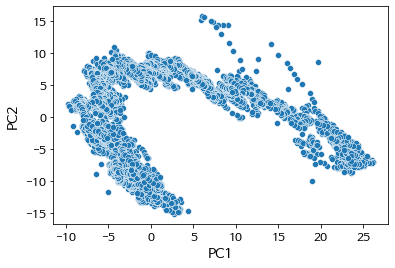

In [27]:
get_pca(X_std_noVIF_scaled)

### 4) RobustScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  0
Empty DataFrame
Columns: [설명가능한 분산 비율(고윳값), 기여율, 누적기여율]
Index: []
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        2.504112e+08  9.512234e-01  0.951223
pca2        1.270614e+07  4.826612e-02  0.999490
pca3        1.252933e+05  4.759448e-04  0.999965
pca4        4.548995e+03  1.728002e-05  0.999983
pca5        1.782726e+03  6.771946e-06  0.999990
...                  ...           ...       ...
pca320      5.505048e-20  2.091173e-28  1.000000
pca321      4.984270e-20  1.893348e-28  1.000000
pca322      4.246752e-20  1.613191e-28  1.000000
pca323      3.624750e-20  1.376914e-28  1.000000
pca324      2.910934e-20  1.105761e-28  1.000000

[324 rows x 3 columns]


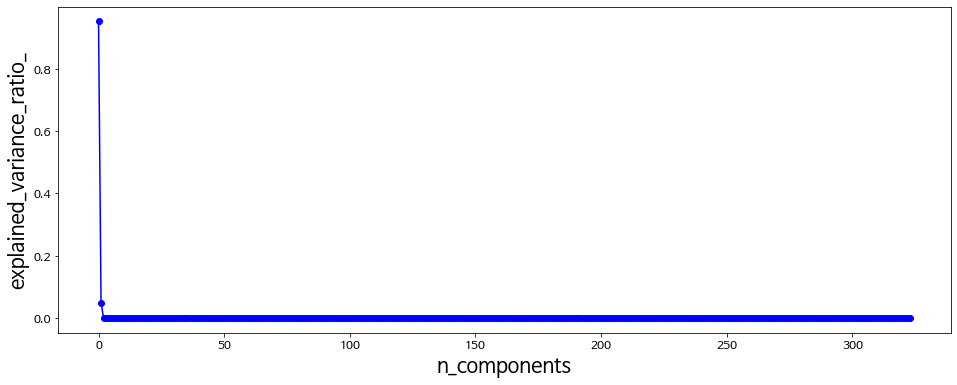

In [28]:
get_pca(X_rbs_noVIF_scaled, len(X_rbs_noVIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                           PC1           PC2
dat...date.name.                            
2016-01-01 07     98678.373109  19199.326759
2016-01-01 08     -1313.265383  16120.229517
2016-01-01 09     -1322.010071  19208.647848
2016-01-01 10     -1318.575077  17995.410351
2016-01-01 11     -1322.123104  19247.934939
...                        ...           ...
2016-12-31 19     -1265.715367   -738.972116
2016-12-31 20     -1265.685125   -738.493458
2016-12-31 21     -1282.967685   5493.588510
2016-12-31 22     -1302.433287  12368.044812
2016-12-31 23     -1284.737590   6118.649414

[8145 rows x 2 columns]


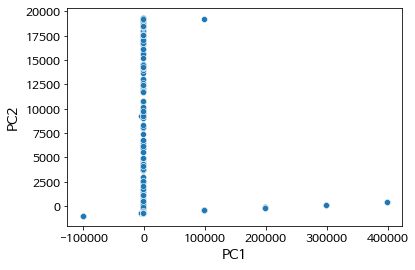

In [29]:
get_pca(X_rbs_noVIF_scaled)

# 함수

## 양품과 불량품의 비율 그래프를 생성하는 함수

In [ ]:
def show_labels_cnt(y_df):
    rows = 2
    cols = 2
    # constrained_layout : 플롯간의 간격을 자동으로 조절
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(10,8))
    for i in range(len(y_df.columns)):
        # 양품의 개수
        good_RD = y_df.iloc[:,i].value_counts()[0]
        # 불량품의 개수
        bad_RD = y_df.iloc[:,i].value_counts()[1]
        # 카운트 그래프
        a = sns.countplot(x=y_df.columns[i], data=y_df, ax=ax[i//2, i%2])
        cnt = 0
        for p in a.patches:
            height = p.get_height() # 그래프의 높이(개수를 그래프위에 표시하기 위해 필요)
            # 개수를 그래프에 표시
            a.text(p.get_x()+p.get_width()/2., height + 0.1, y_df.iloc[:,i].value_counts()[cnt],ha="center")
            cnt += 1
    plt.show()

## 분류에서의 평가지표를 출력해주는 함수

In [ ]:
## 분류에서의 평가지표를 출력해주는 함수
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('정확도:', accuracy)
    print('정밀도:', precision)
    print('재현율:', recall)
    print('F1:', f1)
    print('AUC:', roc_auc)

##   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프를 보여주는 함수

In [ ]:
def show_feature_label(ft_top24, y_df):
    y_df = y_df.set_index(X_data.index)
    rows = 1
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    cnt=0
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

# 모듈 임포트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

# 임계치 : 상위 5%

## 레이블 라벨링

In [ ]:
quartile_5p = y_data.quantile(q=0.95)

print('<각 컬럼의 상위 5% 임계점>\n',quartile_5p)
y_data_labels_5p = pd.DataFrame(np.where(y_data > quartile_5p, 1, 0), columns = y_data.columns)
y_data_labels_5p.head()

<각 컬럼의 상위 5% 임계점>
 L.RD     0.063
L.Vac    0.082
R.RD     0.099
R.Vac    0.037
Name: 0.95, dtype: float64


,L.RD,L.Vac,R.RD,R.Vac
0,0,0,1,1
1,0,0,1,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


### 임계치가 상위 5% 설정의 경우, 카운트 그래프

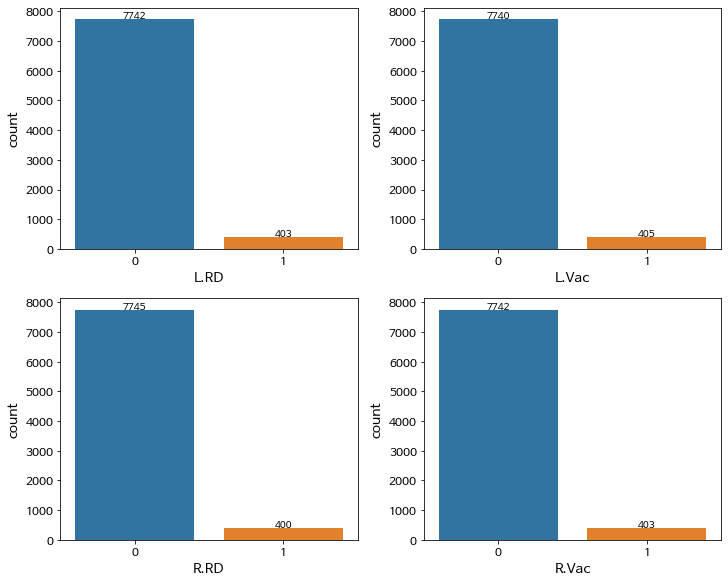

In [ ]:
show_labels_cnt(y_data_labels_5p)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
all_data_5p_LRD = pd.concat([X_data, y_data_labels_5p.iloc[:,0]], axis=1)

X_train_5p, X_test_5p, y_train_5p, y_test_5p = train_test_split(X_data, y_data_labels_5p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_5p.shape)
print(y_test_5p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_5p.value_counts()/y_train_5p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_5p.value_counts()/y_test_5p.count())

(6516,)
(1629,)
0    0.95043
1    0.04957
Name: L.RD, dtype: float64
0    0.95089
1    0.04911
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
print(X_train_5p.shape)
print(y_train_5p.shape)

(6516, 373)
(6516,)


In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9625537139349294
정밀도: 0.7111111111111111
재현율: 0.4
F1: 0.512
AUC: 0.9055196901226599


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapTrueMaxSamplesNone.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapTrueMaxSamplesNone.dot', '-o', 'bootstrapTrueMaxSamplesNone.png', '-Gdpi=600'])

0

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=False)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9607120933087784
정밀도: 0.6538461538461539
재현율: 0.425
F1: 0.5151515151515152
AUC: 0.9233376371852806


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapFalseMaxSamplesNone.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapFalseMaxSamplesNone.dot', '-o', 'bootstrapFalseMaxSamplesNone.png', '-Gdpi=600'])

0

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=0.5)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9607120933087784
정밀도: 0.7222222222222222
재현율: 0.325
F1: 0.44827586206896547
AUC: 0.9092640413169787


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapTrueMaxSamples05.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapTrueMaxSamples05.dot', '-o', 'bootstrapTrueMaxSamples05.png', '-Gdpi=600'])

0

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9625537139349294
정밀도: 0.7111111111111111
재현율: 0.4
F1: 0.512
AUC: 0.9055196901226599


### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.023744
D_AB7_L_UL                             0.010296
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.009584
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.009150
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.008381
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.007573
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV     0.007325
D_AB8_U_LR                             0.007153
N2.TO.EA1313B.1FI33527A_PV             0.007116
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.007112
ROOF.HEATING.Zone80.1JIC31180.PV       0.007087
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.007043
N2.TO.EA1315B.1FI33528A_PV             0.006878
DB.HEAT.TOP.7.1.TMP.1TI40307.PV        0.006733
S_AB1_AB11_L                           0.006713
D_AB8_L_UL                             0.006663
D_AB3_R_UL                             0.006399
ROOF.HEATING.Zone11.1JIC31111.PV       0.006155
D_AB4_L_LR                             0.005986
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.005982
D_AB6_U_LR                             0

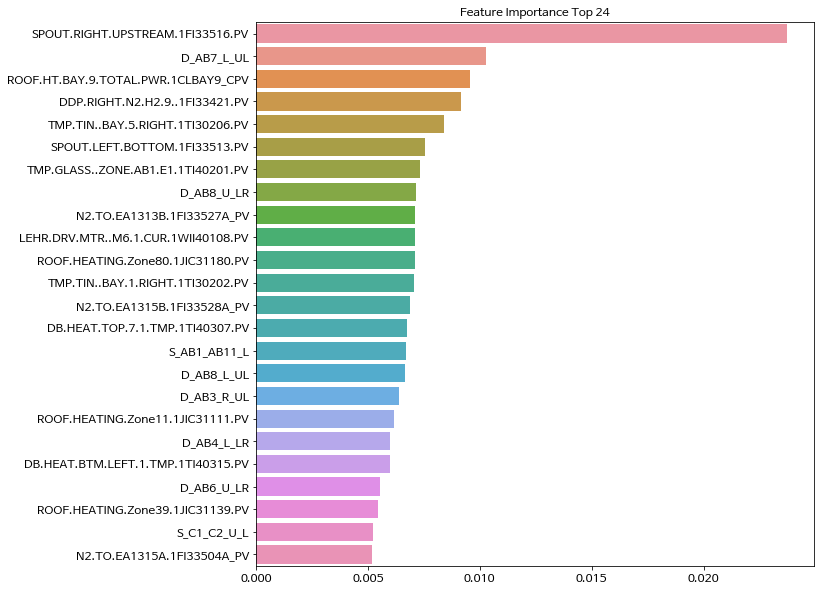

In [ ]:
ft_importance_values_5p = rf_clf_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(모델변수,
                feature_names=X_train_5p.columns,
                out_file='1_randomForest_LRD_5p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_5p_MinMax.dot', '-o', '1_randomForest_LRD_5p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

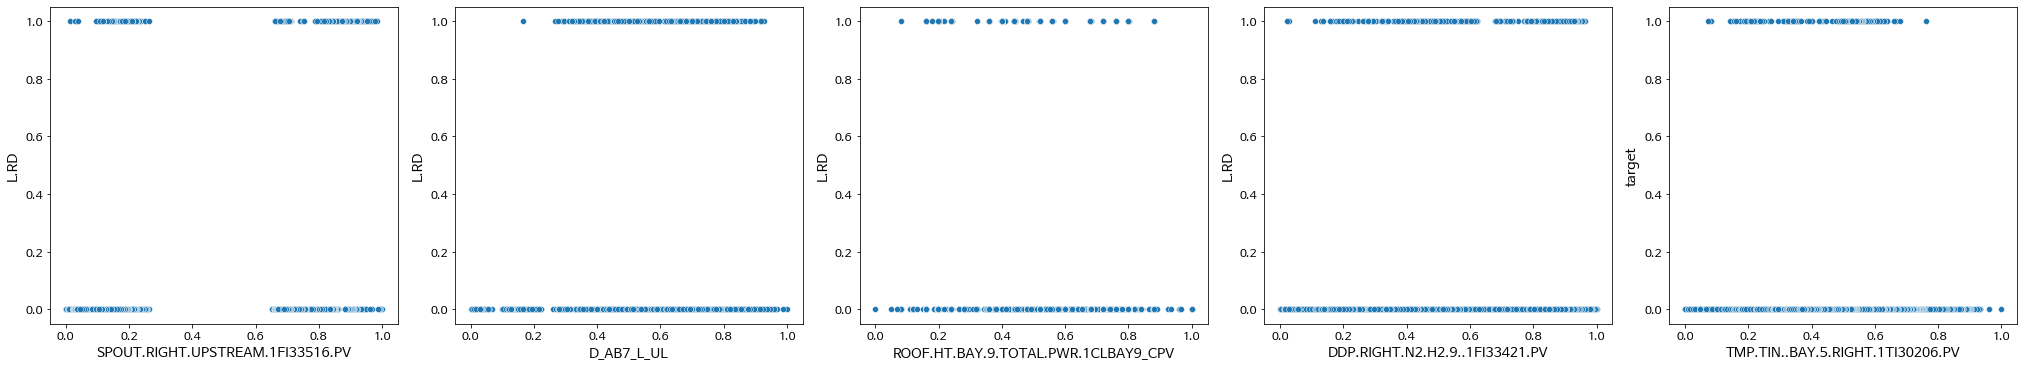

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

## 하이퍼파라미터 튜닝

In [ ]:
params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 17, 19, 20], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50, 100, 130]}

# cv를 5로 설정
# 재현율을 높이도록 하이퍼파라미터 튜닝
gridcv_5 = GridSearchCV(rf_clf_5p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
gridcv_5.fit(X_train_5p, y_train_5p)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
rf_estimator_5p = gridcv_5.best_estimator_
print(rf_estimator_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
rf_estimator_5p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_5p.fit(X_train_5p, y_train_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_predict_5p = rf_estimator_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_estimator_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.958256599140577
정밀도: 0.6875
재현율: 0.275
F1: 0.3928571428571429
AUC: 0.915869109102647


### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.034885
D_AB7_L_UL                             0.028903
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.019026
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.015889
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.014439
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.012364
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.011994
D_AB3_R_UL                             0.010460
DB.BTM.DN.STM.TC.LC.1TI40405_PV        0.010439
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.009596
S_C1_C2_U_L                            0.009542
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.008946
S_AB11_C1_U_L                          0.008784
ATM.N2.H2.5..함유율.1CLFI33402_CPV        0.008659
ROOF.HEATING.Zone41.1JIC31141.PV       0.008601
D_C1_R_UL                              0.008593
D_AB8_L_LR                             0.008533
N2.TO.EA1315B.1FI33528A_PV             0.008232
D_AB4_L_LR                             0.007627
ROOF.HEATING.Zone80.1JIC31180.PV       0.007431
S_AB1_AB11_L                           0

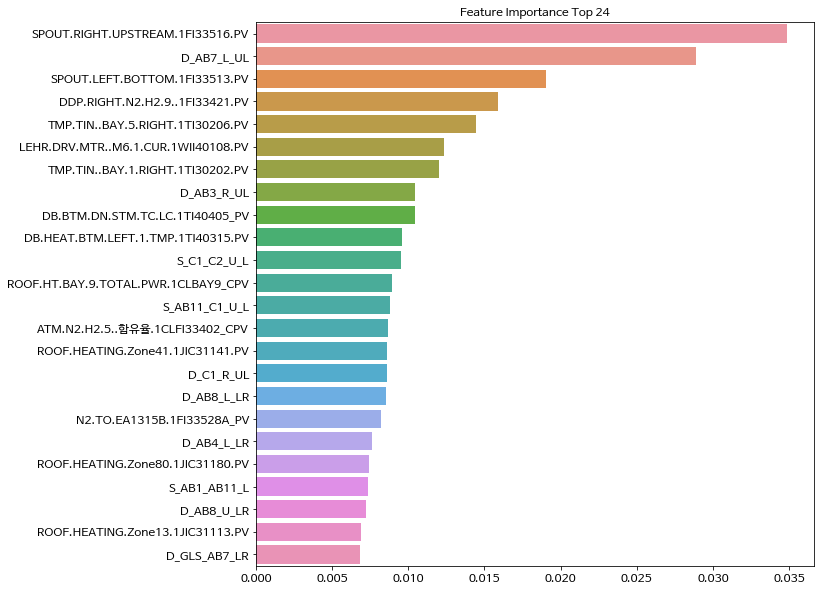

In [ ]:
ft_importance_values_5p = rf_estimator_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

## 피처중요도가 높은 24개의 피처 추출

In [ ]:
X_train_5p_24 = pd.DataFrame(data=X_train_5p,columns=ft_top24.index, index=X_train_5p.index)
X_test_5p_24 = pd.DataFrame(data=X_test_5p,columns=ft_top24.index, index=X_train_5p.index)

In [ ]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False),  n_features_to_select= 5)

rfe_fit = rfe_selector.fit(X_train_5p_24, y_train_5p)

In [ ]:
rfe_selector.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
feature_names = X_train_5p_24.columns
X_train_5p_5 = X_train_5p_24[feature_names[rfe_selector.support_]]
X_test_5p_5 = X_test_5p_24[feature_names[rfe_selector.support_]]

In [ ]:
from sklearn.tree import DicisionTreeClassifier
dt_clf = DicisionTreeClassifier(random_state=42, max_leaf_nodes=20)
dt_clf

ImportError: ignored

### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_estimator_5p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_5p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_5p_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_5p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

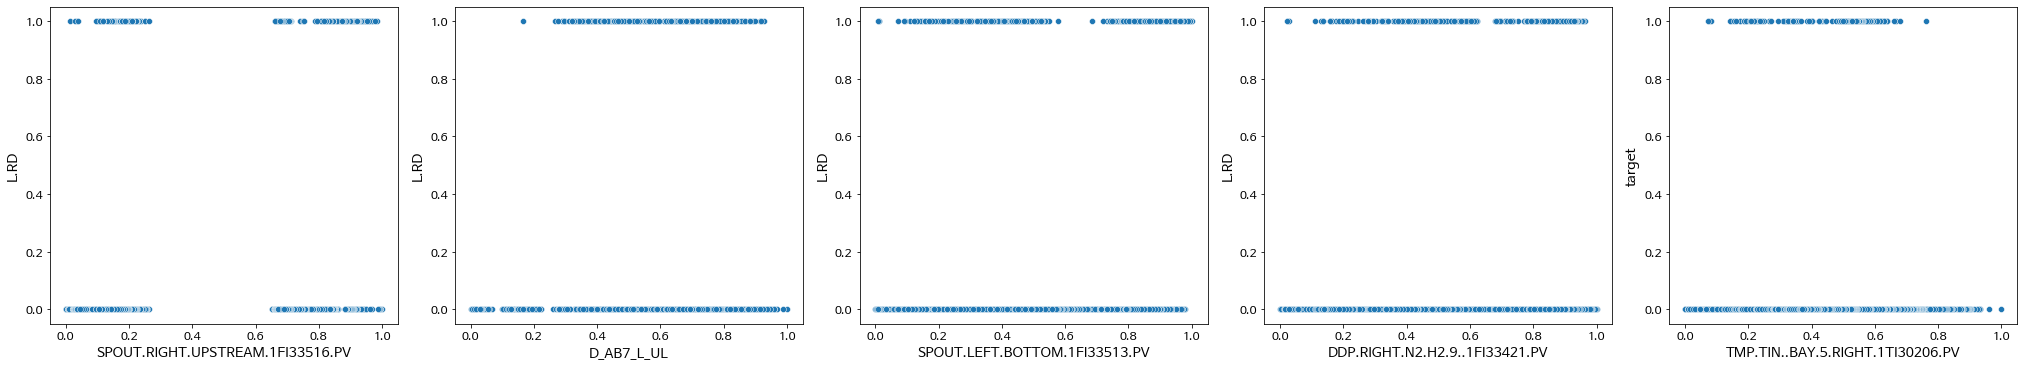

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

# 임계치 : 상위 10%
## 레이블 라벨링

In [ ]:
quartile_10p = y_data.quantile(q=0.9)

print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
y_data_labels_10p = pd.DataFrame(np.where(y_data > quartile_10p, 1, 0), columns = y_data.columns)
y_data_labels_10p.head()

<각 컬럼의 상위 10% 임계점>
 L.RD     0.040
L.Vac    0.050
R.RD     0.066
R.Vac    0.026
Name: 0.9, dtype: float64


,L.RD,L.Vac,R.RD,R.Vac
0,0,1,1,1
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [ ]:
origin_y_data = y_data.copy()
y_data_labels_10p = y_data.copy()

quartile_10p = origin_y_data.quantile(q=0.9)
print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
for i in range(len(origin_y_data.columns)) : 
    column_name = origin_y_data.columns[i]

    # 양품 데이터 설정
    y_data_labels_10p[column_name] = 0
    condition = (origin_y_data[column_name] > quartile_10p[i])
    # 불량품 레이블 데이터 설정
    y_data_labels_10p[column_name][condition] = 1

<각 컬럼의 상위 10% 임계점>
 L.RD     0.040
L.Vac    0.050
R.RD     0.066
R.Vac    0.026
Name: 0.9, dtype: float64


### 임계치가 상위 10% 설정의 경우, 카운트 그래프

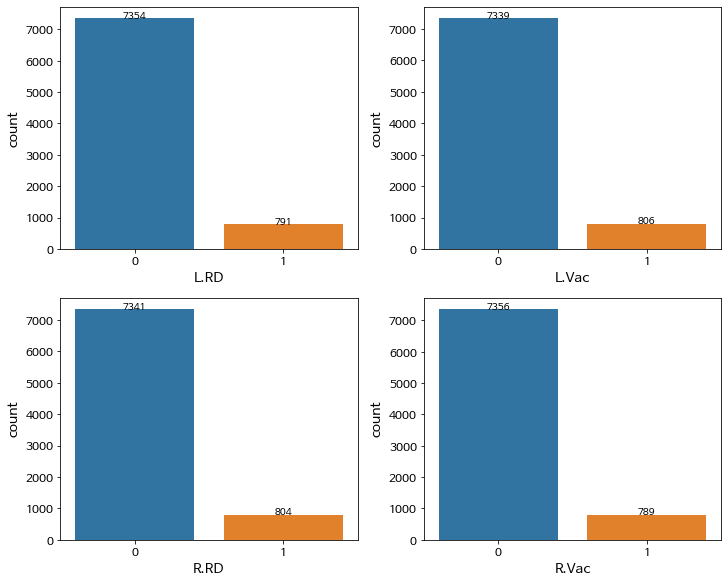

In [ ]:
show_labels_cnt(y_data_labels_10p)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
X_train_10p, X_test_10p, y_train_10p, y_test_10p = train_test_split(X_data, y_data_labels_10p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_10p.shape)
print(y_test_10p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_10p.value_counts() / y_train_10p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_10p.value_counts() / y_test_10p.count())

(6516,)
(1629,)
0    0.902701
1    0.097299
Name: L.RD, dtype: float64
0    0.903622
1    0.096378
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_10p = RandomForestClassifier(random_state=42)
rf_clf_10p.fit(X_train_10p, y_train_10p)
rf_predict_10p = rf_clf_10p.predict(X_test_10p)
rf_predict_proba_10p = rf_clf_10p.predict_proba(X_test_10p)[:,1]
get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

정확도: 0.9238796807857581
정밀도: 0.7037037037037037
재현율: 0.3630573248407643
F1: 0.4789915966386554
AUC: 0.8598812655774023


### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.017466
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.009039
D_AB7_L_UL                             0.008997
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.008361
S_AB10_AB11_L_L                        0.007309
N2.TO.EA1315B.1FI33528A_PV             0.007083
S_AB11_C1_U_L                          0.006919
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.006638
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.006359
N2.TO.EA1313B.1FI33527A_PV             0.006314
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.006153
D_AB3_R_UL                             0.006127
ROOF.HEATING.Zone11.1JIC31111.PV       0.005755
LOWER.C1..Z168.TMP.1TIC42257.PV        0.005681
D_AB6_U_LR                             0.005493
DB.BTM.DN.STM.TC.RC.1TI40407_PV        0.005485
ROOF.HEATING.Zone27.1JIC31127.PV       0.005445
cluster                                0.005368
D_C1_L_UL                              0.005256
D_AB7_L_LR                             0.005242
D_C1_R_UL                              0

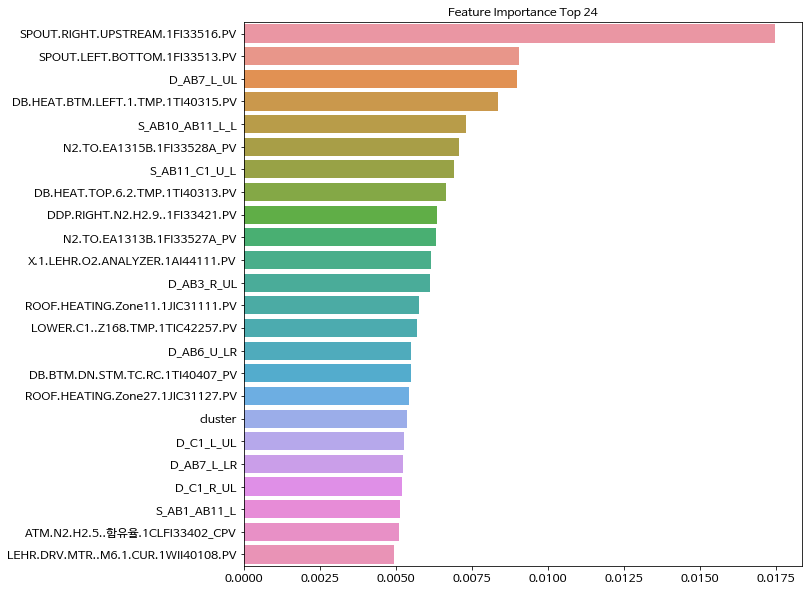

In [ ]:
ft_importance_values_10p = rf_clf_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_clf_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_10p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_10p_MinMax.dot', '-o', working_dir + '1_randomForest_LRD_10p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

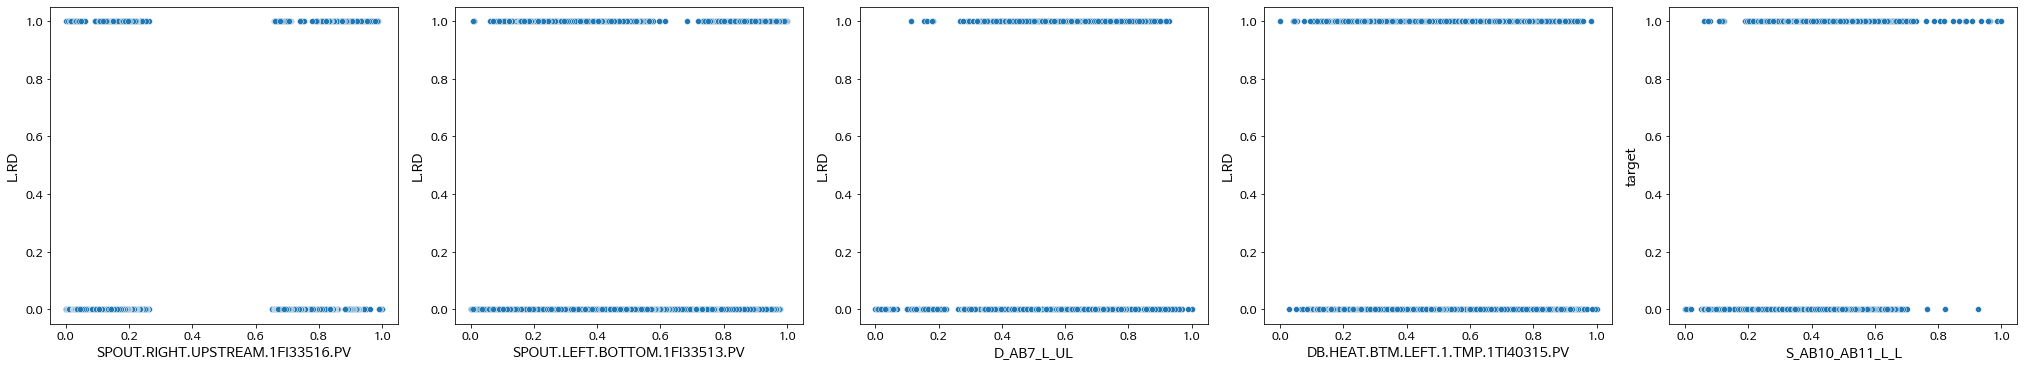

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

## 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_10p = GridSearchCV(rf_clf_10p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_10p.fit(X_train_10p, y_train_10p)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_10p = gridcv_10p.best_estimator_
# print(rf_estimator_10p)
# rf_predict_10p = rf_estimator_10p.predict(X_test_10p)
# rf_predict_proba_10p = rf_estimator_10p.predict_proba(X_test_10p)[:, 1]
# get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
정확도: 0.9220380601596071
정밀도: 0.7419354838709677
재현율: 0.2929936305732484
F1: 0.4200913242009133
AUC: 0.8524430559401828


In [ ]:
rf_estimator_10p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_10p.fit(X_train_10p, y_train_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.033748
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.016409
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.015341
cluster                                0.010601
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.010298
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.010142
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.009402
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.009299
D_C1_L_UL                              0.008755
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.008680
S_AB11_C1_U_L                          0.008481
LOWER.C1..Z168.TMP.1TIC42257.PV        0.008015
D_C1_R_UL                              0.007690
D_AB7_L_UL                             0.007614
D_AB8_R_UL                             0.007363
LOWER.C2..Z182.TMP.1TIC42357.PV        0.007311
D_AB3_R_UL                             0.007213
N2.TO.EA1315B.1FI33528A_PV             0.007120
D_AB8_L_UL                             0.006254
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.006207
D_AB6_U_LR                             0

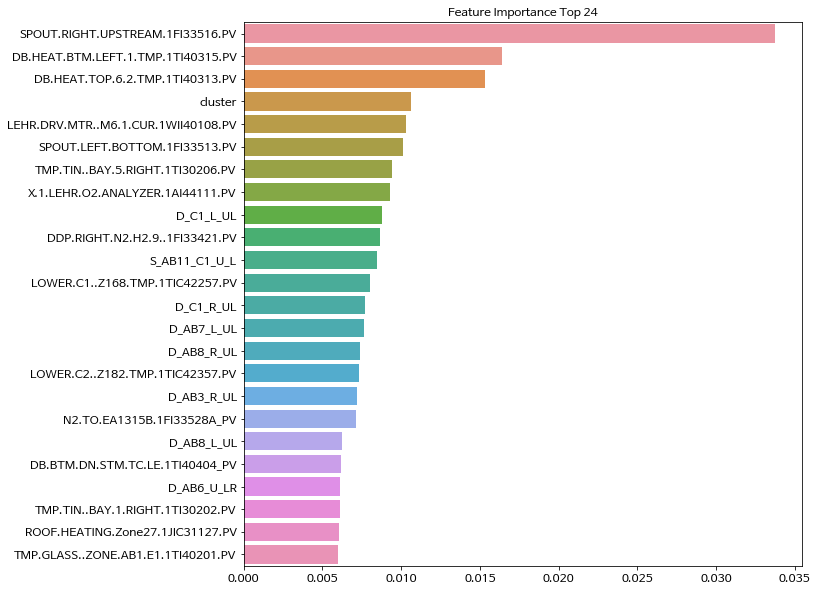

In [ ]:
ft_importance_values_10p = rf_estimator_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_estimator_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_10p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_10p_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_10p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

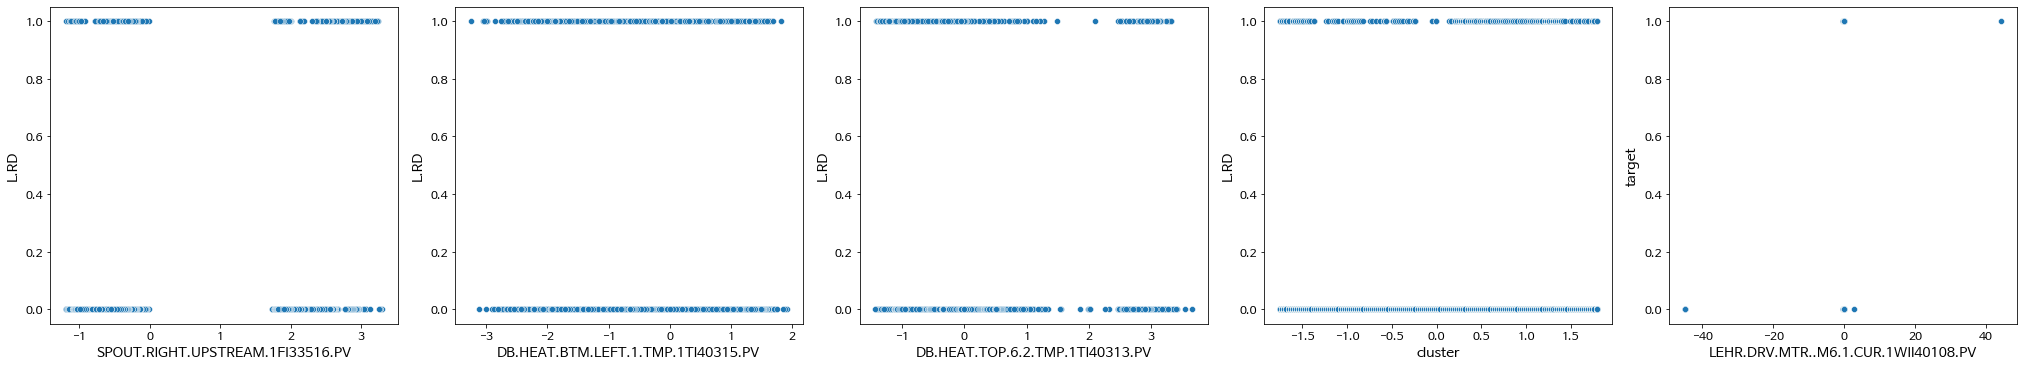

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

# 임계치: 0.01 
- 레이블에 대해 불량품(1)과 양품(0)으로 분류
- 0.01이상의 데이터는 불량품, 이외는 양품으로 Labeling을 한다.


In [ ]:
y_data_labels_001 = pd.DataFrame(np.where(y_data > 0.01, 1, 0), columns = y_data.columns)
y_data_labels_001.head()

,L.RD,L.Vac,R.RD,R.Vac
0,1,1,1,1
1,0,1,1,0
2,1,1,0,0
3,0,1,0,0
4,0,0,0,0


### 임계치가 0.01 설정의 경우, 카운트 그래프

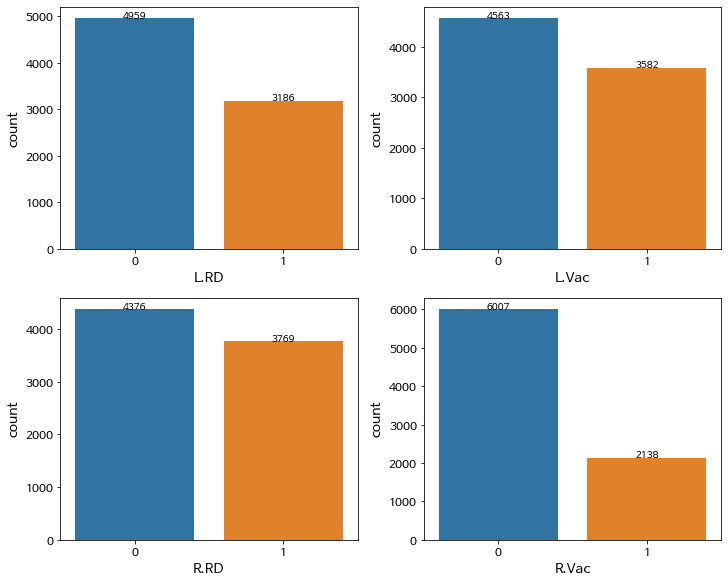

In [ ]:
show_labels_cnt(y_data_labels_001)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
X_train_001, X_test_001, y_train_001, y_test_001 = train_test_split(X_data, y_data_labels_001.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_001.shape)
print(y_test_001.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_001.value_counts()/y_train_001.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_001.value_counts()/y_test_001.count())

(6516,)
(1629,)
0    0.610804
1    0.389196
Name: L.RD, dtype: float64
0    0.600982
1    0.399018
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_001 = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_clf_001.predict(X_test_001)
rf_predict_proba_001 = rf_clf_001.predict_proba(X_test_001)[:,1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6930632289748312
정밀도: 0.6420454545454546
재현율: 0.5215384615384615
F1: 0.5755517826825127
AUC: 0.7385173253712579


### 하이퍼파라미터 튜닝 전의 피처 중요도

S_AB11_C1_U_L                            0.008785
cluster                                  0.007251
S_AB11_C1_L_L                            0.006934
ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV    0.006346
LOWER.C1..Z168.TMP.1TIC42257.PV          0.006305
TMP.TIN..BAY.5.RIGHT.1TI30206.PV         0.005511
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV       0.005288
LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1       0.005207
TMP.TIN..BAY.1.RIGHT.1TI30202.PV         0.004861
D_C1_L_UL                                0.004859
LOWER.C3..Z193TMP.1TIC42454.PV           0.004791
ROOF.HEATING.Zone49.1JIC31149.PV         0.004591
ROOF.HEATING.Zone36.1JIC31136.PV         0.004581
UPPER.C2..Z175.TMP.1TIC42307.PV          0.004574
DB.BTM.UP.STM.TC.RE.1TI40403_PV          0.004570
S_C1_C2_U_L                              0.004454
UPPER.C1..Z155.TMP.1TIC42201.PV          0.004448
ROOF.HEATING.Zone57.1JIC31157.PV         0.004355
S_C2_C3_U_R                              0.004320
ROOF.HEATING.Zone63.1JIC31163.PV         0.004168


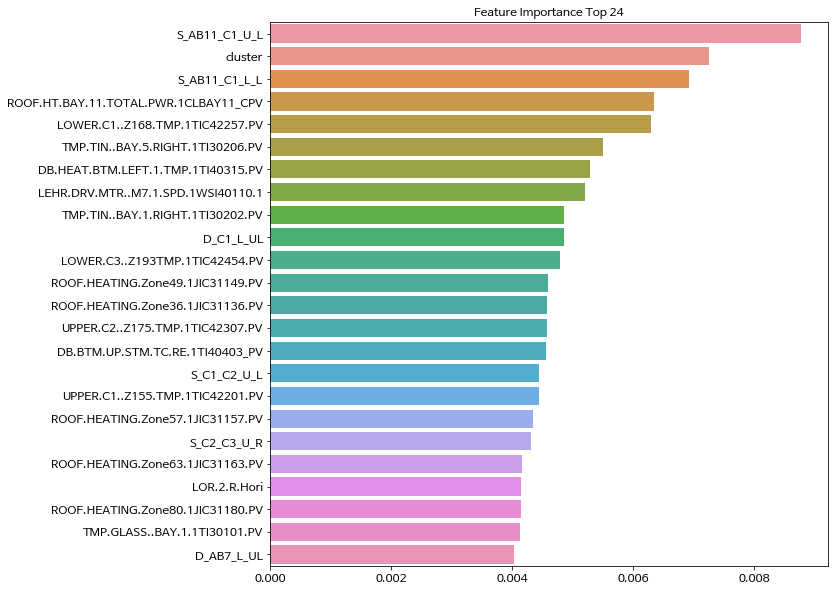

In [ ]:
ft_importance_values_001 = rf_clf_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_clf_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_001_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_001_MinMax.dot', '-o', working_dir + '1_randomForest_LRD_001_MinMax.png', '-Gdpi=600'])

0

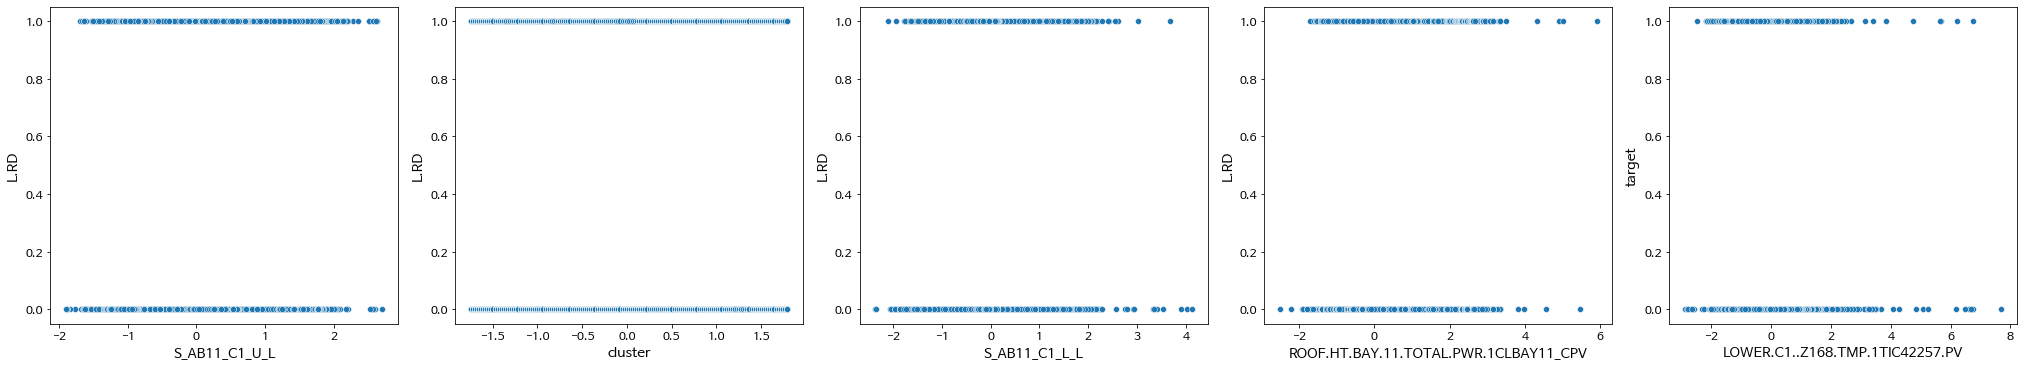

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)

## 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_001 = GridSearchCV(rf_clf_001, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_001.fit(X_train_001, y_train_001)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
# print(rf_estimator_001)
# rf_predict_001 = rf_estimator_001.predict(X_test_001)
# rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
# get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
정확도: 0.6924493554327809
정밀도: 0.6435452793834296
재현율: 0.5138461538461538
F1: 0.5714285714285715
AUC: 0.7359267698593541


In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
rf_estimator_001 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_estimator_001.predict(X_test_001)
rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6924493554327809
정밀도: 0.6435452793834296
재현율: 0.5138461538461538
F1: 0.5714285714285715
AUC: 0.7359267698593541


### 하이퍼파라미터 튜닝 후의 피처 중요도

LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1     0.017240
S_AB11_C1_L_L                          0.011341
cluster                                0.009837
D_C1_L_UL                              0.009624
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.009026
ATM.FLOW.SECT.10.N2.1FIC33417.PV       0.008697
LOWER.C1..Z168.TMP.1TIC42257.PV        0.007849
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.007298
TMP.TIN..BAY.5.LEFT.1TI30205.PV        0.007154
SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.006775
ROOF.HEATING.Zone36.1JIC31136.PV       0.006743
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.006741
TMP.GLASS..Z_RET.E1.1TI40241.PV        0.006639
UPPER.C1..Z155.TMP.1TIC42201.PV        0.006618
TMP.GLASS..BAY.6.1TI30106.PV           0.006544
LOWER.C3..Z193TMP.1TIC42454.PV         0.006104
ROOF.HT.BAY.7.TOTAL.PWR.1CLBAY7_CPV    0.006057
DB.BTM.UP.STM.TC.RE.1TI40403_PV        0.006017
ROOF.HEATING.Zone.9.1JIC31109.PV       0.005542
l_r_tin_bay5                           0.005506
S_AB1_AB2_U_L                          0

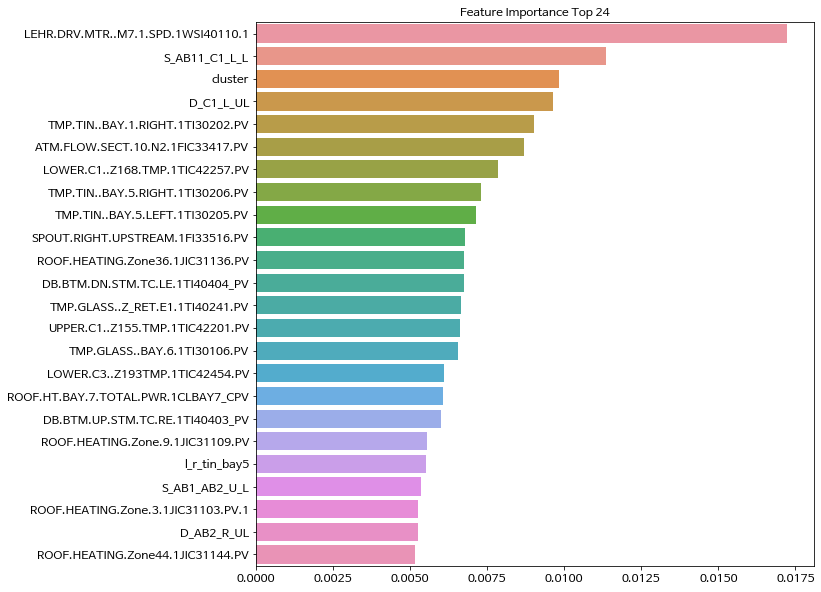

In [ ]:
ft_importance_values_001 = rf_estimator_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_estimator_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_001_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_001_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_001_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

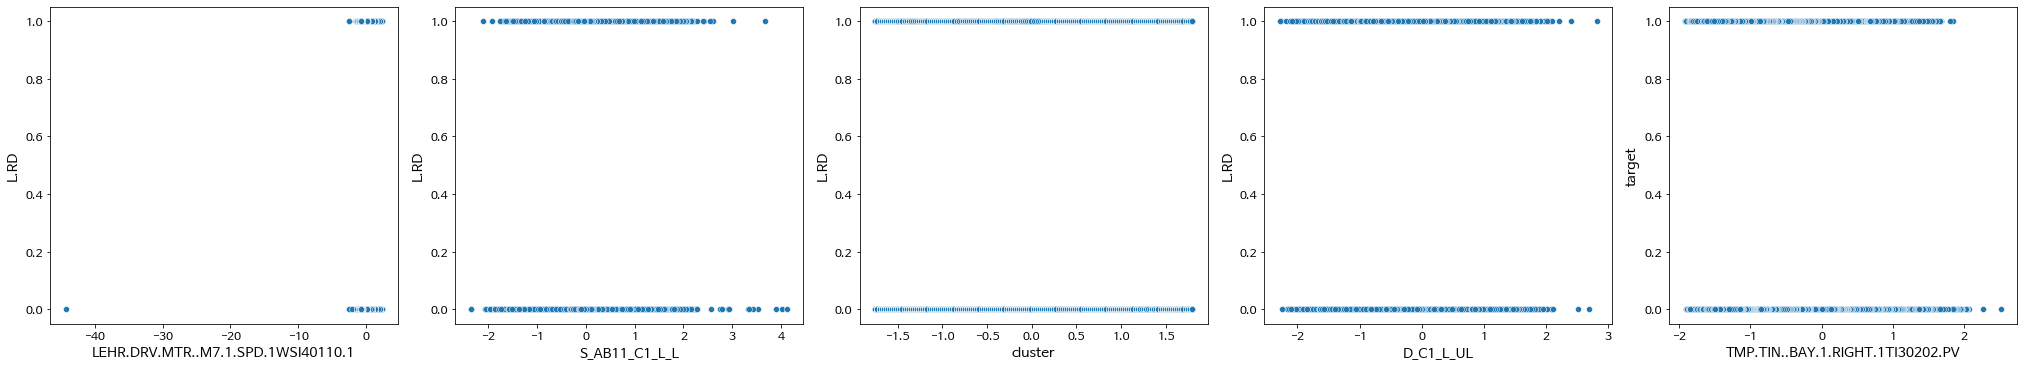

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)